In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import torch
import numpy as np
from tqdm.auto import tqdm

from preprocessing import tokenize, embeddings

/home/local_arnab/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading Data

In [3]:
df = pd.read_csv("Data/df_lyrics.csv")
print(df.shape)
df.head()

(80285, 4)


,Artist,Song,Lyrics,Genre
0,Britney Spears,...Baby One More Time,"Oh, baby, baby Oh, baby, baby Oh, baby, baby...",Pop
1,Britney Spears,Toxic,"Baby, can't you see I'm calling? A guy like y...",Pop
2,Britney Spears,Work Bitch,You wanna? You wanna? You want a hot body? Y...,Pop
3,Britney Spears,Oops!... I Did It Again,"Mmm, yeah Yeah, yeah, yeah, yeah, yeah, yeah ...",Pop
4,Britney Spears,If U Seek Amy,"La, la, la, la, la-la, la, la La, la, la, la,...",Pop


In [4]:
for genre in set(df.Genre):
    print(genre, df[df.Genre == genre].shape[0])

Pop 18275
Rock 21962
Country 21717
Rap 18331


## Preprocessing

In [5]:
tokenizer = tokenize.Tokenizer()
tokenizer.load(path = "Weights/tokenizer.json")
tokenizer.tokenize("I'm a little teapot", get_token_ids=True)

2023-04-17 19:15:52.563054: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


{'tokens': [['<s>', 'I', '_am', '_a', '_little', '_te', 'ap', 'ot', '</s>']],
 'token_ids': [[0, 432, 51, 57, 778, 2153, 1821, 6834, 87]]}

In [6]:
##########################################################
MAX_LENGTH = 1024  # max context length for the tokenizer
##########################################################
lyrics = [l[:min(len(l), MAX_LENGTH)] for l in list(df["Lyrics"])]

proprocessed_lyrics = tokenizer.tokenize(lyrics, get_token_ids=True)

In [7]:
lyrics_token_ids = proprocessed_lyrics["token_ids"]
len(lyrics_token_ids)

80285

In [8]:
shuffle_idx = np.random.permutation(len(lyrics_token_ids))

####################################################################
training_size = 45000
validation_size = 15000
test_size = len(lyrics_token_ids) - training_size - validation_size
####################################################################

training_data = [lyrics_token_ids[i] for i in shuffle_idx[:training_size]]
validation_data = [lyrics_token_ids[i] for i in shuffle_idx[training_size : training_size + validation_size]]
test_data = [lyrics_token_ids[i] for i in shuffle_idx[training_size + validation_size : ]]

print(len(training_data), len(validation_data), len(test_data))

45000 15000 20285


In [9]:
embedder = embeddings.Embedding()
embedder.load("Weights/embeddings_300_w2v.txt")

In [10]:
embedder.embeddings_size

300

In [11]:
embedder.vocab_size

39903

In [12]:
embedding_matrix = []

for idx in tokenizer.index_word:
    word = tokenizer.index_word[idx]
    vec = embedder.model.get_vector(word)
    embedding_matrix.append(torch.tensor(vec))

embedding_matrix = torch.stack(embedding_matrix)
embedding_matrix.shape

torch.Size([39903, 300])

## Modeling

In [13]:
from modeling.models import RNN, LSTM, GRU
from modeling.model_utils import get_fresh_initial_hidden_states, get_parameter_count

In [14]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

###################################################################################
model = GRU( # <--- Change this to LSTM or RNN to try out the other models
    embedding_dim = embedder.embeddings_size,
    hidden_dim = 4 * embedder.embeddings_size,
    vocab_size = embedder.vocab_size,
    pretrained_embeddings = embedding_matrix,
)
###################################################################################

model.to(device)

GRU(
  (word_embeddings): Embedding(39903, 300)
  (dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(300, 1200, num_layers=2, batch_first=True, dropout=0.1)
  (decoder): Linear(in_features=1200, out_features=39903, bias=True)
)

In [15]:
get_parameter_count(model)

73948803

#### Checking if Word2Vec embeddings has been used to initialize the `encoder` module of the model.

In [16]:
model_embedder = model.word_embeddings
for p in model_embedder.parameters():
    print(p.shape)

word = "hello"
emb1 = embedder.model.get_vector(word)
emb2 = model_embedder(torch.tensor(tokenizer.word_index[word]).to(device))

print(emb1.shape, emb2.shape)

assert(torch.isclose(torch.dist(torch.tensor(emb1).to(device), emb2), torch.tensor(0.0))), "Embedding initialization is wrong"

"Initalized embeddings are the same as the pretrained embeddings"

torch.Size([39903, 300])
(300,) torch.Size([300])


'Initalized embeddings are the same as the pretrained embeddings'

In [17]:
tokenized = tokenizer.tokenize(lyrics[0:5], get_token_ids=True)["token_ids"]
min_length = np.array([len(t) for t in tokenized]).min()
batch = torch.stack(
    [torch.tensor(t[:min_length]) for t in tokenized]
)
batch.shape

torch.Size([5, 270])

In [18]:
# y, h = rnn(
#     input = torch.tensor([[tokenizer.word_index[word]]]).to(device), 
#     hidden = torch.zeros(8, 1, model.hidden_dim).to(device)
# )

y, h = model(
    # input = batch.to(device),
    input = batch[:, 10][None].T.to(device),
    hidden = get_fresh_initial_hidden_states(model, batch_size=batch.shape[0])
)

y.shape, h.shape

(torch.Size([5, 1, 39903]), torch.Size([2, 5, 1200]))

In [19]:
batch[:, 10][None].T.shape

torch.Size([5, 1])

In [20]:
# model.load_state_dict(torch.load("Weights/gru_embed_freeze/weights.pth"))

In [21]:
isinstance(model, LSTM)

False

## Intrinsic Eval

In [22]:
# def perplexity(
#         model, sentence_list,
#         tokenizer = None,  # if None, assume sentence_list is already tokenized
#         batch_size = 32,
#         consider_length = 32,   # if the length is too large the perplexity will be infinite
#     ):
#     model.eval()
#     device = next(model.parameters()).device
#     if(tokenizer is not None):
#         tokenized = tokenizer.tokenize([sentence_list], get_token_ids=True)
#         token_ids = tokenized["token_ids"][0]
#     else:
#         token_ids = sentence_list

#     perplexity_track = []
#     with torch.no_grad():
#         for batch_start in tqdm(range(0, len(token_ids), batch_size)):
#             batch_end = min(len(token_ids), batch_start + batch_size)
#             cur_batch_size = batch_end - batch_start
#             min_length = min(consider_length, np.array([len(t) for t in token_ids[batch_start : batch_end]]).min())

#             batch = torch.stack(
#                 [torch.tensor(t[:min_length]) for t in token_ids[batch_start : batch_end]]
#             ).to(device)

#             hidden_state = get_fresh_initial_hidden_states(model, cur_batch_size)
#             # print(batch.shape, hidden_state.shape)

#             log_true_proba = 0
#             for i in range(min_length - 1):
#                 x = batch[:, i][None].T
#                 y_true = batch[:, i+1][None].T
#                 y_pred, hidden_state = model(x, hidden_state)
#                 cur_log_proba = 0
#                 for pred, true in zip(y_pred, y_true):
#                     softmax = torch.nn.functional.softmax(pred.squeeze(), dim = 0)
#                     # print(true[0].item(), softmax[true[0]].item(), torch.log(softmax[true[0]]).item())
#                     cur_log_proba += torch.log(softmax[true[0]])
#                 cur_log_proba /= cur_batch_size
#                 # print(cur_log_proba.item())
#                 log_true_proba += cur_log_proba

#                 # hidden_state = hidden_state.detach()

#             proba = torch.exp(log_true_proba.to(torch.float64))
#             # print(f"log proba = {log_true_proba.item()}", f"p = {proba.item()}")
#             perplexity_track.append(torch.pow(proba, -1/min_length))
    
#     return torch.tensor(perplexity_track).mean().item()
        

from modeling.model_utils import perplexity

init_perplexity = perplexity(
    model, validation_data, batch_size = 128, consider_length = 64
)

perplexity_track = [init_perplexity]

100%|██████████| 118/118 [00:50<00:00,  2.32it/s]


In [23]:
perplexity_track

[32708.00546682894]

## Training

In [24]:
learning_rate = 0.001
num_epochs = 10
batch_size = 128

cross_entropy = torch.nn.CrossEntropyLoss().to(device)
tunable_params = [
    p for n, p in model.named_parameters() if "word_embeddings" not in n # tune all weights but the embeddings
]

optimizer = torch.optim.Adam(tunable_params, lr = learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [25]:
loss_track = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}:")
    model.train()
    loss = 0
    for batch_start in tqdm(range(0, len(training_data), batch_size)):
        batch_end = min(len(training_data), batch_start + batch_size)
        cur_batch_size = batch_end - batch_start

        tokenized = training_data[batch_start : batch_end]
        min_length = np.array([len(t) for t in tokenized]).min()
        batch = torch.stack(
            [torch.tensor(t[:min_length]) for t in tokenized]
        ).to(device)

        # start fresh for each sentence
        hidden_state = get_fresh_initial_hidden_states(model, cur_batch_size)
        
        for i in range(min_length - 1):
            x = batch[:, i][None].T
            y_true = batch[:, i+1][None].T
            y_pred, hidden_state = model(x, hidden_state)
            for pred, true in zip(y_pred, y_true):
                loss += cross_entropy(pred.squeeze(), true[0])
        
        loss_track.append(loss.item()/cur_batch_size)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        model.zero_grad()
        loss = 0
    
    print("calculating perplexity on validation set")
    pp = perplexity(model, validation_data, batch_size=batch_size, consider_length=64)
    print(f"perplexity = {pp}") 
    perplexity_track.append(pp)
    print("-----------------------------------------")

Epoch 1:


100%|██████████| 352/352 [04:49<00:00,  1.22it/s]


calculating perplexity on validation set


100%|██████████| 118/118 [00:51<00:00,  2.29it/s]


perplexity = 705.1420548043538
-----------------------------------------
Epoch 2:


 76%|███████▌  | 267/352 [03:36<01:07,  1.26it/s]

### Saving model weights

In [ ]:
import os
import json

save_dir = "Weights/gru_embed_freeze_2" # <--- change this to save to a different directory
os.makedirs(save_dir, exist_ok=True)

torch.save(model.state_dict(), f"{save_dir}/weights.pth")
with open(f"{save_dir}/logs.json", "w") as f:
    json.dump({
        "loss_track": loss_track,
        "perplexity_track": perplexity_track
    }, f)

Text(0, 0.5, 'Loss')

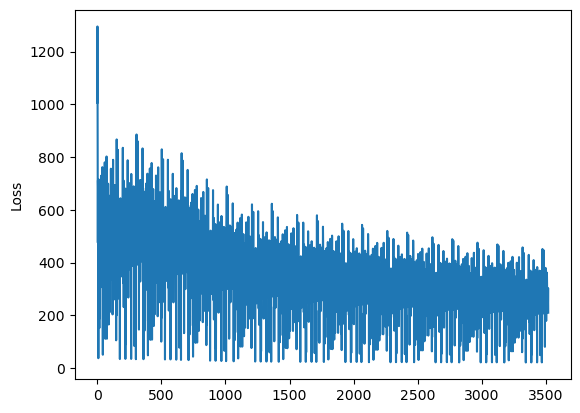

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_track)
plt.ylabel("Loss")

Text(0.5, 0, 'Epoch')

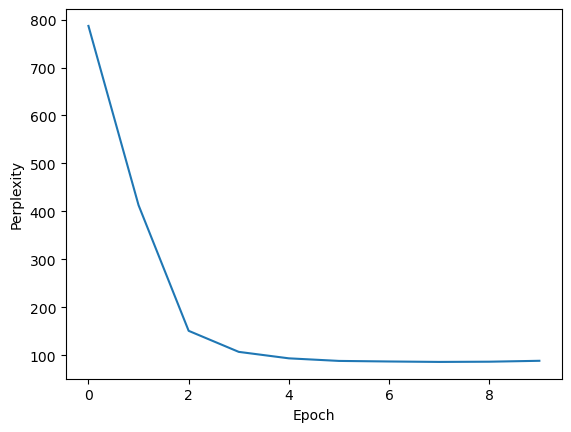

In [ ]:
plt.plot(perplexity_track[1:])
plt.ylabel("Perplexity")
plt.xlabel("Epoch")

## Generation

In [ ]:
# def generate(
#         model, tokenizer, 
#         prompt="", max_new_tokens = 10, top_k = 5,
#         debug = False,
#     ):
#     model.eval()
#     device = next(model.parameters()).device
#     tokenized = tokenizer.tokenize([prompt], get_token_ids=True)
#     token_ids = tokenized["token_ids"][0][:-1]  # remove the </s> token
#     end_of_sent = tokenizer.word_index[tokenizer.SENT_END]

#     # start fresh for each sentence
#     hidden_state = get_fresh_initial_hidden_states(model, 1)
    
#     for p in token_ids:
#         x = torch.tensor([[p]]).to(device)
#         y_pred, hidden_state = model(x, hidden_state)
    
#     last_token = token_ids[-1]
#     generated_tokens = []
#     for i in range(max_new_tokens):
#         # print(hidden_state.norm().item())
#         y_pred, hidden_state = model(
#             torch.tensor([[last_token]]).to(device), hidden_state
#         )
#         y_pred = y_pred.squeeze()
#         y_pred = torch.nn.functional.softmax(y_pred, dim = 0)
#         y_pred = y_pred.cpu().detach().numpy()
#         top_k_idx = y_pred.argsort()[-top_k:][::-1]
#         top_k_values = y_pred[top_k_idx]

#         if(debug):
#             print(top_k_idx)
#             print([(tokenizer.index_word[t], np.round(v, 4)) for t, v in zip(top_k_idx, top_k_values)])
        
#         top_k_probs = top_k_values / np.sum(top_k_values)
#         sampled_idx = np.random.choice(top_k_idx, p = top_k_probs)
#         token_ids.append(sampled_idx)
#         last_token = sampled_idx
#         generated_tokens.append(sampled_idx)
#         if(sampled_idx == end_of_sent):
#             break
    
#     return {
#         "text": tokenizer.decode([token_ids + generated_tokens])[0],
#         "generated_tokens": generated_tokens,
#     }

from modeling.model_utils import generate

In [ ]:
gen_lyrics = generate(model, tokenizer, top_k = 10, max_new_tokens=50, debug = True)
gen_lyrics["text"]

[   4    7   42  479   80 2859  210    1   63  432]
[('_', 0.1281), ('_I', 0.1133), ('_(', 0.0898), ('You', 0.0383), ('_You', 0.0225), ('The', 0.0163), ('_Yeah', 0.0162), ('_Oh', 0.0152), ('_The', 0.0143), ('I', 0.0143)]
[ 51  18  75  68  32   6  89  10  90 493]
[('_am', 0.0924), ('_have', 0.0812), ('_do', 0.0799), ('_got', 0.047), ('_want', 0.0455), ('_was', 0.0411), ('_cannot', 0.04), ('_know', 0.0356), ('_see', 0.0275), ('_can', 0.0259)]
[ 57  13 188 313 124 147  77 226 286  15]
[('_a', 0.098), ('_not', 0.0644), ('_just', 0.0419), ('_going', 0.0352), ('_on', 0.0312), ('_in', 0.0275), ('_the', 0.0265), ('_so', 0.0241), ('_about', 0.0189), ('_here', 0.0168)]
[  9   2  20  57  33  77 804 213 730  73]
[('_to', 0.9408), (',', 0.008), ('_you', 0.0032), ('_a', 0.0024), ('_it', 0.0023), ('_the', 0.0018), ('_To', 0.0017), ('_again', 0.0013), ('_being', 0.0013), ('_that', 0.0012)]
[  34 3570  344  303   75  205   18  179   21  101]
[('_be', 0.0709), ('_introduce', 0.0522), ('_make', 0.0356), 

" I am about to be back again. I am just a rapper but you are going to make me want the man to tell you a nigga who needs to know you, who you like? You need a friend who gon' be like me. I am about to be back again. I am just a rapper but you are going to make me want the man to tell you a nigga who needs to know you, who you like? You need a friend who gon' be like me."

## Sampling comparison

In [ ]:
import json

In [ ]:
model_types = {"rnn": RNN, "lstm": LSTM, "gru": GRU}

for m_type in model_types:
    model = model_types[m_type](
        embedding_dim = embedder.embeddings_size,
        hidden_dim = 4 * embedder.embeddings_size,
        vocab_size = embedder.vocab_size,
        pretrained_embeddings = embedding_matrix,
    )
    
    model.to(device)
    print(f"loading {m_type} model", type(model))
    model.load_state_dict(torch.load(f"Weights/{m_type}_embed_freeze/weights.pth"))

    samples = []
    for i in tqdm(range(50)):
        samples.append(
            generate(model, tokenizer, top_k = 10, max_new_tokens=50)["text"]
        )

    with open(f"Results/{m_type}.json", "w") as f:
        json.dump(samples, f)

loading rnn model <class '__main__.RNN'>


100%|██████████| 50/50 [00:07<00:00,  6.66it/s]


loading lstm model <class '__main__.LSTM'>


100%|██████████| 50/50 [00:07<00:00,  6.61it/s]


loading gru model <class '__main__.GRU'>


100%|██████████| 50/50 [00:07<00:00,  6.59it/s]
